# ISUP3 : Machine Learning

*stolen from Maxime Sangnier*


# JAFUNO Douba


## Gaussian mixture models and k-means

### Gaussian mixture models

Three functions are provided below. They are aimed at:

1. plotting the "contour" of a covariance matrix;
1. generating a covariance matrix;
1. sampling from a Gaussian mixture model.

In [1]:
from sklearn import datasets as data
import numpy as np
import scipy.stats as stat
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cov(cov, mean=[0, 0], cst=6, num=200):
    """Display the ellipse associate to the covariance matrix cov.
    If mean is specified, the ellipse is translated accordingly.
    """
    cov = np.linalg.inv(np.asarray(cov))
    mean = np.asarray(mean)
    theta = np.linspace(0, 2*np.pi, num=num)
    X = np.c_[np.cos(theta), np.sin(theta)]
    X = X.T * np.sqrt(cst / np.diag(X.dot(cov.dot(X.T))))
    X = X.T + mean
    plt.plot(X[:, 0], X[:, 1], 'r')
    
def covariance(sigma1=1., sigma2=1., theta=0.):
    """
        Covariance matrix with eigenvalues sigma1 and sigma2, rotated by the angle theta.
    """
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    cov = np.array([[sigma1, 0.],
                   [0, sigma2]])
    return rotation.dot(cov.dot(rotation.T))

In [2]:
def sample_gm(weights, means, covariances, size=1):
    """Sample points from a Gaussian mixture model specified by the weights, the means
    and the covariances. These three parameters are lists."""
    X = None
    p = np.random.multinomial(1, weights, size=size)
    for (m, c, i) in zip(means, covariances, p.T):
        Y = np.random.multivariate_normal(m, c, size=size)
        if X is None:
            X = Y.copy()
        else:
            X[i==1] = Y[i==1]
    return X

Draw a sample of size 200 from a Gaussian mixture model with parameters
$$
    \begin{cases}
        \pi_1 &= 0.33\\
        \mu_1 &= (0, 0),
    \end{cases}
$$
$$
    \begin{cases}
        \pi_2 &= 0.33\\
        \mu_2 &= (5, 0),
    \end{cases}
$$
$$
    \begin{cases}
        \pi_3 &= 0.34\\
        \mu_3 &= (2, -5),
    \end{cases}
$$
and with same identity covariance matrix.
Plot the "contours" of the three clusters.

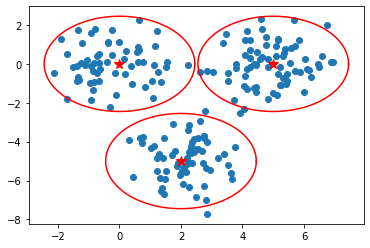

In [3]:
# Answer
(weights, means, covariances) = ([0.33, 0.33, 0.34],
                                 [[0, 0], [5, 0], [2, -5]],
                                 [(1, 1, 0), (1, 1, 0), (1, 1, 0)])

X = sample_gm(weights, means, [covariance(*c) for c in covariances], size=200)

plt.scatter(X[:,0], X[:, 1])
for mean, cov_param in zip(means, covariances):
    plt.plot(mean[0], mean[1], 'r*', markersize=10)
    plot_cov(covariance(*cov_param), mean)

Complete the following emplementation of soft k-means.

In [4]:
class SoftKMeans(object):
    def __init__(self, n_components=1, n_iter=100):
        self.n_components = n_components
        self.n_iter = n_iter
    
    def fit(self, X):
        # Initialization
        n_components = self.n_components
        weights = [1/n_components] * n_components  # List of initial weights
        #means = [np.random.rand(X.shape[1]) * (X.max(axis=0)-X.min(axis=0)) + X.min(axis=0)
        #        for k in range(n_components)]
        means = np.random.permutation(X)[:n_components]  # List of initial means
        # (initial means can be taken at random among the training points)
        covariances = [np.eye(X.shape[1]) for k in range(n_components)]  # List of initial
        # covariance matrices
        
        # Multivariate Gaussian pdf
        def pdf(X, mean, cov):
            invcov = np.linalg.inv(cov + 1e-6*np.eye(cov.shape[0]))
            r = np.exp(-0.5*np.diag((X-mean).dot(invcov.dot((X-mean).T))))
            r *= np.sqrt(np.linalg.det(invcov/(2*np.pi)))
            return r
            
        # Loop
        log_likelihood = []  # Marginal log-likelihood at each iteration
        em_log_likelihood = []  # Average joint log-likelihood at each iteration
        for it in range(self.n_iter):
            # Parameter update
            # Matrix of joint density values (size #components x #points)
            joint_density = np.array([w * pdf(X, m, c)
                                      for w, m, c in zip(weights, means, covariances)])
            p = joint_density / joint_density.sum(axis=0)  # Conditional probabilities
            weights = p.mean(axis=1)  # Prior probabilities
            means = p.dot(X) / p.sum(axis=1)[:, np.newaxis]  # Means
            covariances = [(X-m).T.dot(np.diag(w).dot(X-m)) / w.sum()
                           for w, m in zip(p, means)]  # List of covariance matrices
            
            # Log-likelihood computation
            log_likelihood.append(np.log(joint_density.sum(axis=0)).sum())
            em_log_likelihood.append(np.sum(p * np.log(joint_density)))
        self.weights_ = np.array(weights)
        self.means_ = np.array(means)
        self.covariances_ = np.array(covariances)
        self.log_likelihood_ = log_likelihood
        self.em_log_likelihood_ = em_log_likelihood

Fit a soft k-means with 3 components and 20 iterations on the data.
Print the prior probabilities.
Plot the training dataset along the means and the covariance matrices estimated.

Are the results consistent with the way the data has been generated?

Les poids sont: [0.29815675 0.37181606 0.33002719]


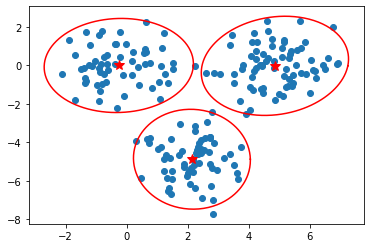

In [5]:
km=SoftKMeans(n_components=3,n_iter=20)
km.fit(X)
print("Les poids sont: "+str(km.weights_))
plt.scatter(X[:,0],X[:,1])
for mean,cov in zip(km.means_,km.covariances_):
    plot_cov(cov, mean, cst=6, num=200)
    plt.plot(mean[0], mean[1], 'r*', markersize=10)

Plot the two log-likelihoods versus the number of iterations.
Is the marginal log-likelihood non-decreasing?
Is it bounded from below by the average joint log-likelihood?

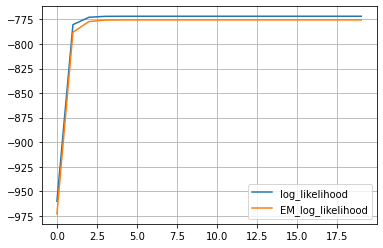

In [6]:
plt.plot(range(km.n_iter),km.log_likelihood_,label="log_likelihood")
plt.plot(range(km.n_iter),km.em_log_likelihood_,label="EM_log_likelihood")
plt.grid()
plt.legend()


With the help of the [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture), estimate the parameters of a 3-components Gaussian mixture.
Print the prior probabilities and the maximal value of log-likelihood.
Plot the training dataset along the means and the covariance matrices estimated.

Are the results consistent with the your own implementation?

prior_probability [0.29843975 0.37149223 0.33006801]
maximal value of log-likelihood -3.859031571156129


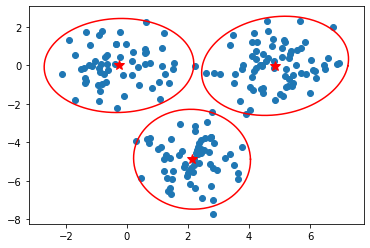

In [7]:
from sklearn.mixture import GaussianMixture
gM=GaussianMixture(n_components=3)
gM.fit(X)
print('prior_probability',gM.weights_)
print("maximal value of log-likelihood",gM.lower_bound_ )
plt.scatter(X[:,0],X[:,1])
for mean,cov in zip(gM.means_,gM.covariances_):
    plot_cov(cov, mean, cst=6, num=200)
    plt.plot(mean[0], mean[1], 'r*', markersize=10)

Repeat the estimation several (let us say 9) times.
Are the results stable?

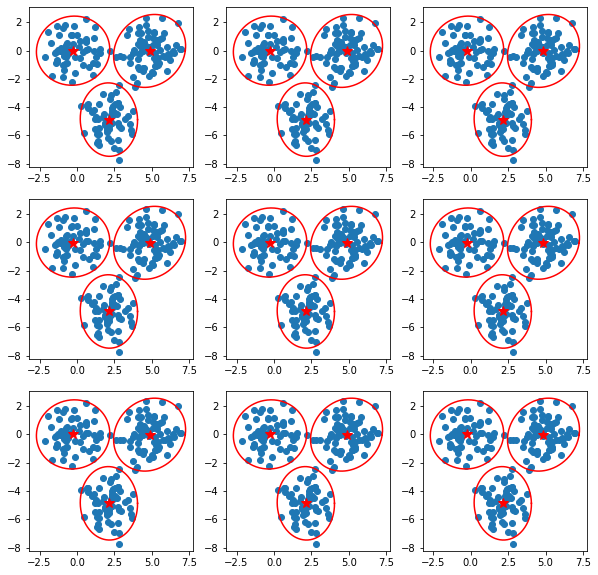

In [8]:
# Answer
gmm = GaussianMixture(n_components=3)

plt.figure(figsize=(10, 10))
for it in range(9):
    gmm.fit(X)
    
    plt.subplot(3, 3, it+1)
    plt.scatter(X[:, 0], X[:, 1])
    for (mean, cov) in zip(gmm.means_, gmm.covariances_):
        plt.plot(mean[0], mean[1], 'r*', markersize=10)
        plot_cov(cov, mean)

What if initial parameters are set at random (look for the suitable parameter of [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture))?

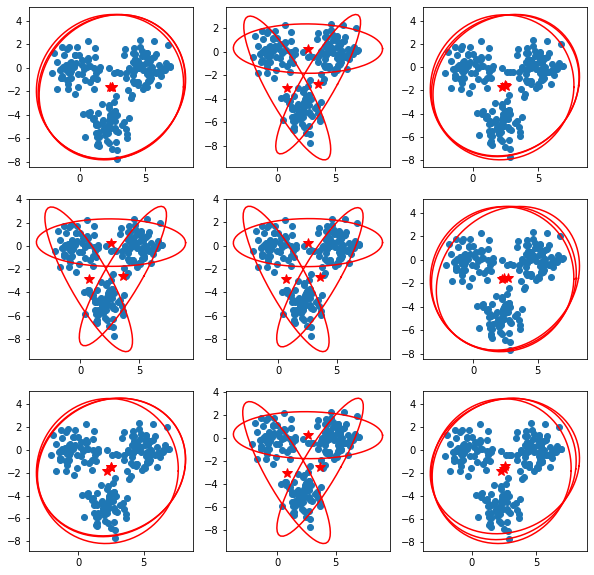

In [9]:
# Answer
gmm = GaussianMixture(n_components=3, init_params="random")
plt.figure(figsize=(10, 10))
for it in range(9):
    gmm.fit(X)
    
    plt.subplot(3, 3, it+1)
    plt.scatter(X[:, 0], X[:, 1])
    for (mean, cov) in zip(gmm.means_, gmm.covariances_):
        plt.plot(mean[0], mean[1], 'r*', markersize=10)
        plot_cov(cov, mean)

Complete the following script in order to:
1. sample from a Gaussian mixture;
1. fit a  [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) model;
1. plot the training set, the means and the variance "contours".

Analyze the results (there should be "unexpected" results).

''

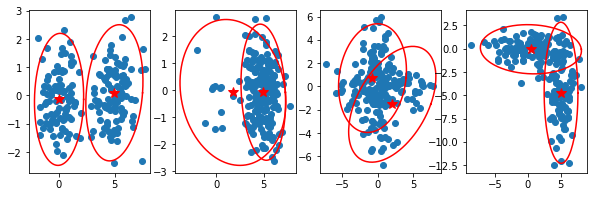

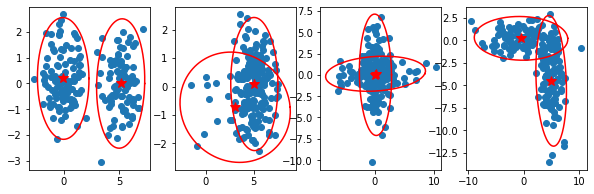

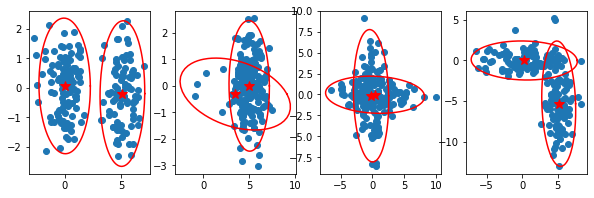

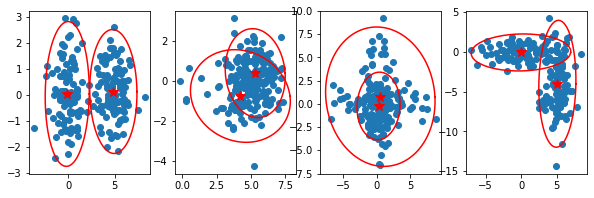

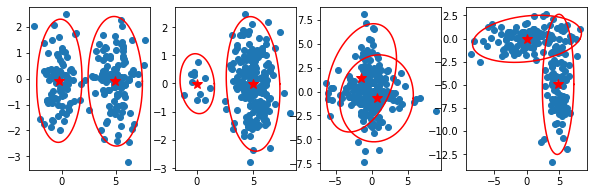

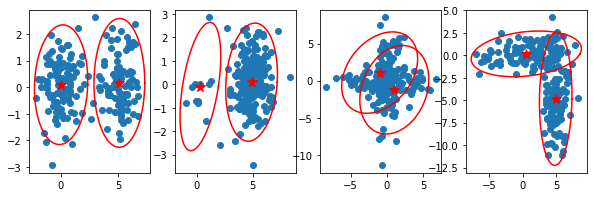

In [10]:
gmm = GaussianMixture(n_components=2)

for it in range(6):
    plt.figure(figsize=(10, 3))
    for it, (weights, means, covariances) in enumerate([
        ([0.5, 0.5], [[0, 0], [5, 0]], [(1, 1, 0), (1, 1, 0)]),
        ([0.05, 0.95], [[0, 0], [5, 0]], [(1, 1, 0), (1, 1, 0)]),
        ([0.5, 0.5], [[0, 0], [0, 0]], [(10, 1, 0), (1, 10, 0)]),
        ([0.5, 0.5], [[0, 0], [5, -5]], [(10, 1, 0), (1, 10, 0)])]):
        X=sample_gm(weights, means, [covariance(*c) for c in covariances], size=200)
        gmm.fit(X)
        plt.subplot(1, 4,it+1)
        plt.scatter(X[:,0],X[:,1])
        for mean,cov in zip(gmm.means_,gmm.covariances_):
            plot_cov(cov, mean, cst=6, num=200)
            plt.plot(mean[0], mean[1], 'r*', markersize=10)
;

### k-means

In [11]:
from matplotlib import cm

def map_regions(clf, data=None, num=500):
    """
        Map the regions f(x)=1…K of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: classifier with a method predict
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = clf.predict(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cm.coolwarm,
              alpha=0.3)

Given the followin data, fit a [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture).
Display the cluster centers along with the partitioning (use the function *map\_regions*).

In [12]:
(weights, means, covariances) = ([0.3, 0.2, 0.5], [[-5, -1], [5, 0], [2, -5]],
                                 [(1, 5, np.pi/3), (1, 5, np.pi/3), (5, 1, np.pi/3)])
X = sample_gm(weights, means, [covariance(*c) for c in covariances], size=200)

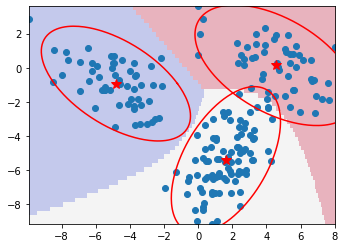

In [13]:
gmm=GaussianMixture(n_components=3)
gmm.fit(X)
plt.scatter(X[:,0],X[:,1])
for (mean, cov) in zip(gmm.means_, gmm.covariances_):
    plt.plot(mean[0], mean[1], 'r*', markersize=10)
    plot_cov(cov, mean)
map_regions(gmm,data=X,num=200)

Do the same with [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
What is the difference?

In [14]:
from sklearn.cluster import KMeans



Given the following dataset, perform several [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering with a random initialization (original version of k-means).
What do you observe?

In [15]:
(weights, means, covariances) = ([0.05, 0.2, 0.75], [[-5, -1], [5, 0], [2, -5]],
                                 [(1, 5, np.pi/3), (1, 5, np.pi/3), (5, 1, np.pi/3)])
X = sample_gm(weights, means, [covariance(*c) for c in covariances], size=100)

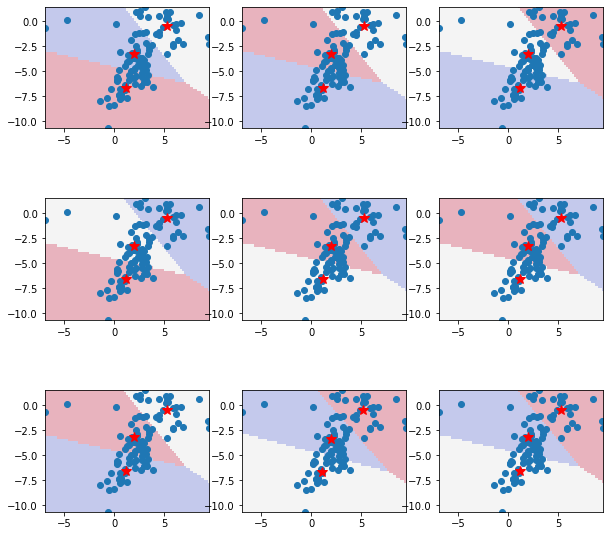

In [16]:
# Answer
clt = KMeans(n_clusters=3, init="random")

plt.figure(figsize=(10, 10))
for it in range(9):
    clt.fit(X)

    plt.subplot(3, 3, it+1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.plot(clt.cluster_centers_[:, 0], clt.cluster_centers_[:, 1], 'r*', markersize=10)
    map_regions(clt, data=X)
    plt.axis("image");


Here, we aim at analyzing [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) and [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for non-convex clusters.
For this purpose:
1. generate [moons](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) (then [circles](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles)) with noise set to $0.1$;
1. plot the two classes with *plotXY*;
1. display the two-cluster partitioning (*map\_regions*) obtained with [Gaussian mixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) and [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

What do you observe?

In [17]:
def plotXY(X, Y):
    """Scatter the points of two classes.
    Usage:
        plotXY(X1, X2), where X1 and X2 are the data matrices for the two classes.
        plot(X, Y), where X is the data matrix and Y the label vector.
    """
    if X.shape == Y.shape:
        X1 = X
        X2 = Y
    else:
        X1 = X[Y == Y.max()]
        X2 = X[Y == Y.min()]
    plt.plot(X1[:, 0], X1[:, 1], ">", label="Class 1")
    plt.plot(X2[:, 0], X2[:, 1], "d", label="Class 2")
    plt.axis('equal')

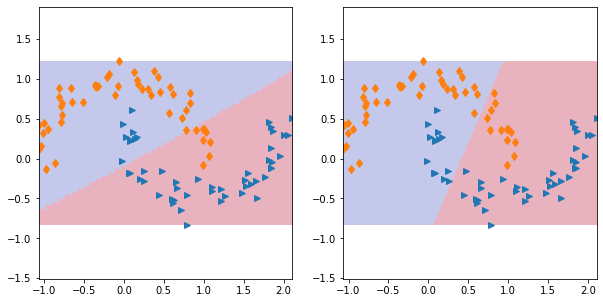

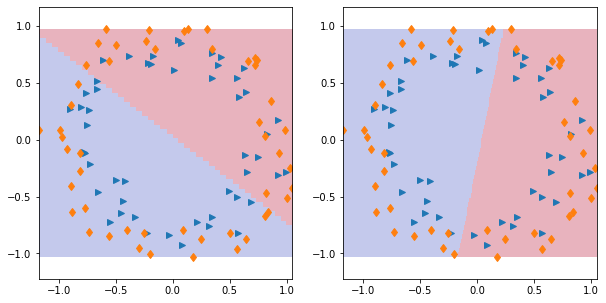

In [18]:
from sklearn.datasets import make_moons, make_circles

for make_data in [make_moons, make_circles]:
    X, y = make_data(noise=0.1)
    plt.figure(figsize=(10, 5))
    for it, clf in enumerate([GaussianMixture(n_components=2),KMeans(n_clusters=2, init="random")]):
        plt.subplot(1,2,it+1)
        plotXY(X,y)
        clf.fit(X)
        map_regions(clf, data=X)